# Histopathologic Cancer Detection: Check.
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability. 

Challenges
* Normalize staining (https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085)
* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from time import time
from tqdm import tqdm_notebook

from keras.layers import Input, Dense, Flatten, Conv2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

from data.data import load_data

from skimage import exposure
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 32
ONLY_USE_SUBSET = True # Set to true when running locally
DIMENSIONS = (96, 96)

## Importing dataset
In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In [3]:
(x_train, y_train, meta_train), (x_valid, y_valid, meta_valid), (x_test, y_test, meta_test) = load_data()

NotImplementedError: Direct download currently not working. Please go to https://drive.google.com/drive/folders/1gHou49cA1s5vua2V5L98Lt8TiWA3FrKB and press download all. Then place files (ungzipped) in ~/.keras/datasets/pcam.

## Exploratory Data Analysis

In [11]:
#df_data = pd.read_csv('./data/train_labels.csv')
#df_data['id'] = df_data['id'].astype(str) + '.tif'

#df_data_test = pd.read_csv('./data/sample_submission.csv')
#df_data_test['id'] = df_data_test['id'].astype(str) + '.tif'

label_count = np.ravel(y_train).value_counts()
plt.figure(figsize=(8,6))
sns.barplot(label_count.index, label_count.values, alpha=0.8)
plt.title('Label distribution of train set')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

Here, we visualize some data from the training set, and the corresponding label.

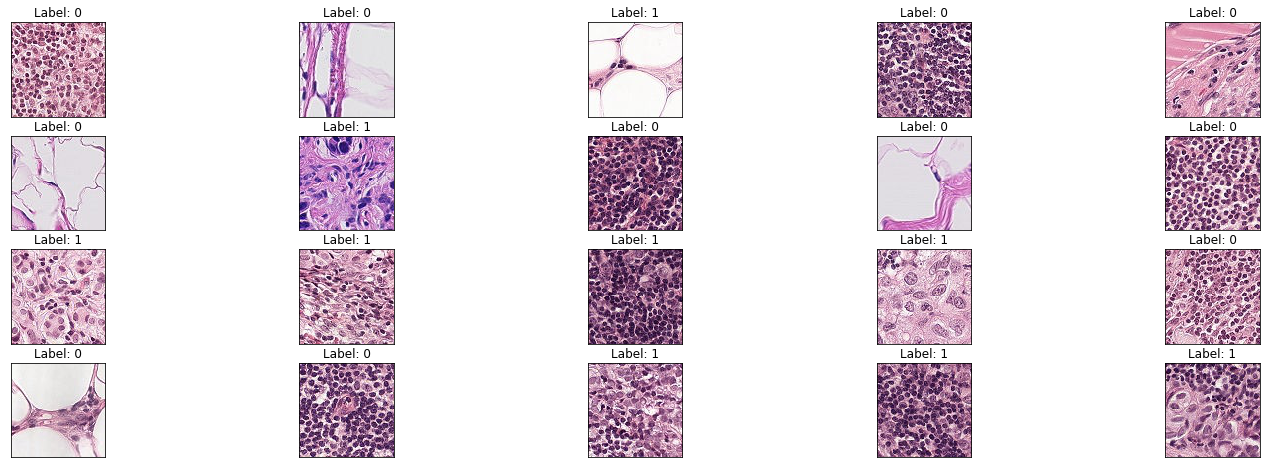

In [19]:
fig = plt.figure(figsize=(25, 8))
# display 20 images
train_imgs = os.listdir("./data/train")

random_images = np.random.choice(train_imgs, 20)
for idx, img_name in enumerate(random_images):
    ax = fig.add_subplot(4, 10//2, idx+1, xticks=[], yticks=[])
    im = Image.open("./data/train/" + img_name)
    plt.imshow(im)
    label = df_data.loc[df_data['id'] == img_name, 'label'].values[0]
    ax.set_title('Label: {}'.format(label))

Next, we load the data into memory. When the parameter `ONLY_USE_SUBSET` is set, we only import a small test for testing purposes on your own machine.

In [32]:
# Load data into memory
df_data_copy = df_data
if ONLY_USE_SUBSET:
    df_data_copy = df_data_copy[0:20000]

x_train = []
y_train = np.array(df_data_copy['label'])
for file_path in tqdm_notebook(df_data_copy['id']):
    x_train.append(np.array(Image.open('data/train/{}'.format(file_path))))
x_train = np.array(x_train)

Below, we create ImageDataGenerators for the train, validation, and test set. 
Augmentations can be specified below. For more information about augmentations, please inspect the [Keras documentation](https://keras.io/preprocessing/image/)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Specify other augmentations here.
)

print("[>] Creating validation_generator")
validation_generator = train_datagen.flow(
    x=x_valid,
    y=np.ravel(y_valid),
    batch_size=BATCH_SIZE)

print("[>] Creating train_generator")
train_generator = train_datagen.flow(
    x=x_train,
    y=np.ravel(y_train),
    batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("[>] Creating test_generator")
test_generator = test_datagen.flow(
    x=x_test,
    y=np.ravel(y_test),
    batch_size=1,
    seed=0,
    shuffle=False
)

[>] Creating validation_generator
[>] Creating train_generator
[>] Creating test_generator


## Create the Network
Next, we create the network using the Keras functional API.

In [9]:
inputs = Input(shape=(*DIMENSIONS,3,))

x = Conv2D(1, (3,3))(inputs)
x = Conv2D(1, (1,1))(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 1)         28        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 94, 1)         2         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8836)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                282784    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total para

## Train the network
Next, we train the network. I've added multiple handy callbacks, such as TensorBoard, ModelCheckpoint, and EarlyStopping.

In [10]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
# modelcheckpoint = ModelCheckpoint(modelcheckpoint_name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# earlystopping = EarlyStopping(monitor='val_loss', patience=1)
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_generator),
                    epochs=10, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_generator))
                    #callbacks=[tensorboard]

Epoch 1/10
1451/8192 [====>.........................] - ETA: 6:45 - loss: 0.6901 - acc: 0.5338

KeyboardInterrupt: 

## Make a prediction
Finally, we make a prediction. The prediction will be saved to [data/submission.csv](data/submission.csv).

Note: method performs slow if run multiple times. One run will take approximately 70 seconds.

In [42]:
prediction = model.predict_generator(test_generator, verbose=1)
submission = pd.read_csv('./data/sample_submission.csv')
submission['label'] = prediction
submission.to_csv('./data/submission.csv', index=False)


57458/57458 [==============================] - 67s 1ms/step
